#Imports and stuff

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     |████████████████████████████████| 50 kB 5.7 MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-gvwt3kd0
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-gvwt3kd0
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=a203558f625842202321974a84cd84fbd97cac5322205ac2f1a19785726d14b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ik3i0a3/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [ ]:
"""
Fix to use keras_vggface
"""
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm.notebook import tqdm
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras_vggface.vggface import VGGFace

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12587133256651797542
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11667172877108038101
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


#Data (processing and generator)

In [ ]:
!unzip -q './gdrive/My Drive/MatteProj/train-faces.zip'

In [ ]:
df = pd.read_csv('./gdrive/My Drive/MatteProj/train-pairs.csv')

In [ ]:
df = df[['fid1','p1','p2']]
df.columns = ['fam','p1','p2']

In [ ]:
# df = df[:len(df)//4]

**Generating dataframe (kin_df) with pairs of positive and randomly sampled negative examples:**

In [ ]:
kin_df = []
for row in tqdm(df.iterrows()):
    row = row[1]
    p1_ls = os.listdir('./train-faces/'+row['p1'])
    p2_ls = os.listdir('./train-faces/'+row['p2'])

    for f1 in p1_ls:
        file1 = row['p1']+'/'+f1
        for f2 in p2_ls:
            file2 = row['p2']+'/'+f2
            kin_df.append([file1, file2, 1])
            fam_flag = True
            while(fam_flag):
                f_row = df.sample().iloc[0]
                fam_flag = f_row['fam']==row['fam']
                if(fam_flag):
                    continue
                n = os.listdir('./train-faces/'+f_row['p2'])
                fam_flag = len(n)==0
            file2 = f_row['p2']+'/'+np.random.choice(n)
            kin_df.append([file1, file2, 0])

kin_df = pd.DataFrame(kin_df)
kin_df.columns = ['file1','file2','kin']

0it [00:00, ?it/s]

In [ ]:
kin_df.head()

,file1,file2,kin
0,F0001/MID1/P00007_face1.jpg,F0001/MID3/P00006_face0.jpg,1
1,F0001/MID1/P00007_face1.jpg,F0701/MID5/P07332_face1.jpg,0
2,F0001/MID1/P00008_face4.jpg,F0001/MID3/P00006_face0.jpg,1
3,F0001/MID1/P00008_face4.jpg,F0416/MID4/P04370_face1.jpg,0
4,F0001/MID1/P00003_face0.jpg,F0001/MID3/P00006_face0.jpg,1


In [ ]:
len(kin_df)

529080

In [ ]:
sum(kin_df['kin'].values)/len(kin_df)

0.5

**Splitting training and validation data. Using 90-10 split because of large dataset (~529k pairs).**


In [ ]:
train_val_split = 0.8
train_len = int(len(kin_df)*train_val_split)
val_len = (len(kin_df)-train_len)//2
test_len = val_len

In [ ]:
train_kin_df = kin_df[:train_len]
val_kin_df = kin_df[train_len:-val_len]
test_kin_df = kin_df[-val_len:]

In [ ]:
train_kin_df = train_kin_df.sample(train_len).reset_index(drop=True)

In [ ]:
img_folder = './train-faces'

In [ ]:
batch_size = 64

## Generator (generates batches for training)

**Using keras.preprocessing.image.ImageDataGenerator() for data augmentation and image processing**

In [ ]:
def get_gens():

    datagen = image.ImageDataGenerator(rescale = 1./255, 
                                       horizontal_flip = True,
                                       rotation_range = 20,
                                       zoom_range = 0.2,
                                       brightness_range = (0.8,1)) 
    
    gen1 = datagen.flow_from_dataframe(dataframe = train_kin_df, 
                                       directory = img_folder, 
                                       x_col = "file1",
                                       y_col = "kin",
                                       class_mode = "raw",
                                       target_size = (200,200), 
                                       batch_size = batch_size,
                                       shuffle = False)
    
    gen2 = datagen.flow_from_dataframe(dataframe = train_kin_df,
                                       directory = img_folder,
                                       x_col = 'file2',
                                       class_mode = None,
                                       target_size = (200,200),
                                       shuffle = False,
                                       batch_size = batch_size)

    

    val_datagen = image.ImageDataGenerator(rescale = 1./255)

    val_gen1 = val_datagen.flow_from_dataframe(dataframe = val_kin_df, 
                                               directory = img_folder, 
                                               x_col = "file1",
                                               y_col = "kin",
                                               class_mode = "raw",
                                               target_size = (200,200), 
                                               batch_size = batch_size,
                                               shuffle = False)
    
    val_gen2 = val_datagen.flow_from_dataframe(dataframe = val_kin_df,
                                               directory = img_folder,
                                               x_col = 'file2',
                                               class_mode = None,
                                               target_size = (200,200),
                                               shuffle = False,
                                               batch_size = batch_size)
    
    return gen1,gen2,val_gen1,val_gen2

In [ ]:
gen1, gen2, val_gen1, val_gen2 = get_gens()

Found 423264 validated image filenames.
Found 423264 validated image filenames.
Found 52908 validated image filenames.
Found 52908 validated image filenames.


**Custom generator to generate batches of image pair ([x1,x2]) and label (y).**

In [ ]:
def generator(generator1, generator2):
    while True:
        X1,Y = generator1.next()
        X2 = generator2.next()
        yield (X1,X2),Y

### Testing custom generator

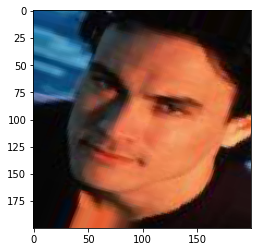

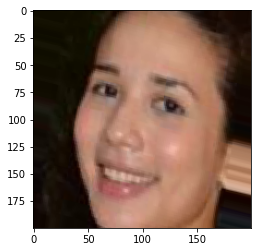

0


In [ ]:
(x1,x2),y = next(generator(gen1,gen2))
plt.imshow(x1[0])
plt.show()
plt.imshow(x2[0])
plt.show()
print(y[0])

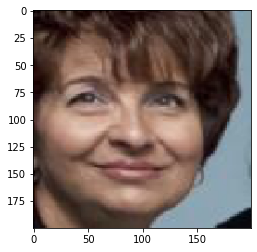

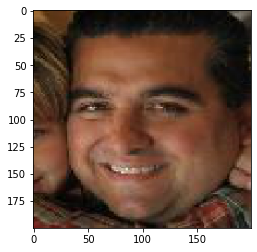

1


In [ ]:
(x1,x2),y = next(generator(val_gen1,val_gen2))
plt.imshow(x1[0])
plt.show()
plt.imshow(x2[0])
plt.show()
print(y[0])

# Model

In [ ]:
"""
Final model with ResNet50 (VGGFace) backbone with weighted L1 dist
"""
def get_model():

    inpt1 = keras.layers.Input((200,200,3))
    inpt2 = keras.layers.Input((200,200,3))

    base_model = get_backbone()

    x1 = base_model(inpt1)
    x2 = base_model(inpt2)
    x = keras.layers.Subtract()([x1,x2])
    
    """L2 dist"""
    # x = keras.layers.Lambda(lambda y: K.sqrt(K.sum(K.square(y), axis=-1, keepdims=True)))(x)
    
    """Weighted L1 dist"""
    x = keras.layers.Lambda(lambda y: K.abs(y))(x)

    """Weighted L2 dist"""
    # x = keras.layers.Multiply()([x,x])
    
    x = keras.layers.BatchNormalization()(x)
    out = keras.layers.Dense(1,activation='sigmoid')(x)
    model = keras.models.Model([inpt1,inpt2],out)

    return model

In [ ]:
"""
Resnet50 (VGGFace) backbone used in the final model
"""

def get_backbone():
    
    inpt = keras.layers.Input((200,200,3))
    base = VGGFace(model='resnet50', include_top=False)
    
    # do_train = False
    # for l in base.layers:
    #     l.trainable = do_train
    #     if(not(do_train) and l.name.split('_')[0]=='conv5'):
    #         do_train = True
    
    x = base(inpt)
    x = keras.layers.GlobalAveragePooling2D()(x)
    model = keras.models.Model(inpt,x)

    return model

# Training

## Custom losses

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

In [ ]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

## Callbacks

In [ ]:
csv_path = './gdrive/My Drive/MatteProj/vgg_face_l1_nb3_2.csv'
cp_path = './gdrive/My Drive/MatteProj/vgg_face_l1_nb3_2.h5'
cp_acc_path = './gdrive/My Drive/MatteProj/vgg_face_l1_nb3_2_best_acc.h5'

In [ ]:
cp = keras.callbacks.ModelCheckpoint(cp_path, monitor='val_loss', save_best_only=True)
cp_acc = keras.callbacks.ModelCheckpoint(cp_acc_path, monitor='val_acc', save_best_only=True)
csvl = keras.callbacks.CSVLogger(csv_path)
# reduce_lr = keras.callbacks.ReduceLROnPlateau()

Learning rate per epoch:


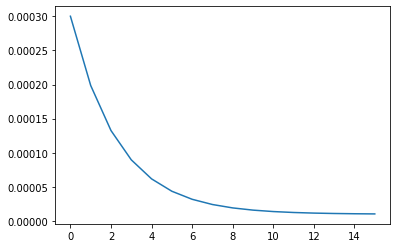

In [ ]:
EPOCHS = 16

start_lr = 3e-4
min_lr = 1e-5
# max_lr = 5e-4 * tpu_strategy.num_replicas_in_sync
max_lr = 3e-4
rampup_epochs = 0
sustain_epochs = 0
exp_decay = .65

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

## Train

Initialise generators

In [ ]:
gen1, gen2, val_gen1, val_gen2 = get_gens()

Found 423264 validated image filenames.
Found 423264 validated image filenames.
Found 52908 validated image filenames.
Found 52908 validated image filenames.


Initialise model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_23 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          (None, 2048)         23561152    ['input_22[0][0]',               
                                                                  'input_23[0][0]']        

Compile and train

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=['acc'])
# model.compile(optimizer=keras.optimizers.adam_v2.Adam(1e-3),loss=contrastive_loss,metrics=['binary_accuracy'])

history = model.fit(generator(gen1,gen2),
                    steps_per_epoch = train_len//batch_size//8,
                    epochs = 24,
                    validation_data = generator(val_gen1,val_gen2),
                    validation_steps = val_len//batch_size,
                    callbacks = [cp,cp_acc,csvl])

# Inference

In [ ]:
(x1,x2),y = next(generator(val_gen1,val_gen2))
pred = model.predict([x1,x2])

In [ ]:
acc = 0.
th = 0.5
for i in range(len(y)):
    if((y[i]==1 and pred[i]>th) or (y[i]==0 and pred[i]<th)):
        acc+=1
print(acc/len(y))

0.75


In [ ]:
model.evaluate(generator(val_gen1,val_gen2),batch_size=128,steps=val_len//batch_size)

In [ ]:
val_len

52908